In [680]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import DataLoader, TensorDataset, random_split 

import torchvision.transforms.functional as fn
from torchvision import datasets
from torchvision import transforms as T

from torchmetrics import Accuracy

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split 

import cv2
from PIL import Image

from tqdm import tqdm 

In [681]:
transforms_train = T.Compose([T.ToTensor(), T.Resize(size = (128, 128)), T.Normalize(mean = [0.7437, 0.5865, 0.5869], std = [0.0816, 0.1087, 0.1215])])
transforms_valid = T.Compose([T.ToTensor(), T.Resize(size = (128, 128)), T.Normalize(mean = [0.7437, 0.5865, 0.5869], std = [0.0816, 0.1087, 0.1215])])

In [682]:
#train_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', transform = transforms_train)
data = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', 
                            transform = T.Compose([T.ToTensor(),
                                                   T.Resize(size = (64, 64))]))

In [683]:
t, _ = random_split(data, (300, len(data)-300), generator = tc.Generator().manual_seed(42))

In [684]:
#valid_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Test', transform = transforms_valid)
train_dataset, valid_dataset = random_split(t, (250, len(t)-250), generator = tc.Generator().manual_seed(42))

In [685]:
len(train_dataset), len(valid_dataset)

(250, 50)

In [686]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [687]:
class CNNModel(nn.Module):
    
    def __init__(self, num_filters, kernel_size, num_classes):
        super().__init__()
        
        self.conv1 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1, bias = True)
        self.bn1 = nn.LazyBatchNorm2d()
        
        self.mpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn2 = nn.LazyBatchNorm2d()
        
        self.mpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn3 = nn.LazyBatchNorm2d()
        
        self.mpool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn4 = nn.LazyBatchNorm2d()
        
        self.mpool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1, bias = True)
        self.bn5 = nn.LazyBatchNorm2d()
        
        self.mpool5 = nn.MaxPool2d(2, 2)
        
        self.conv6 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1, bias = True)
        self.bn6 = nn.LazyBatchNorm2d()
        
        self.mpool6 = nn.MaxPool2d(2, 2)
        
        self.conv7 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn7 = nn.LazyBatchNorm2d()
        
        self.apool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        
        self.fc = nn.LazyLinear(num_classes)
        
        self.seq = nn.Sequential(nn.LazyLinear(128), nn.ReLU(), nn.LazyLinear(16), nn.ReLU(), nn.LazyLinear(num_classes))
        
    def forward(self, x):
        
        y = self.conv1(x)
        y = self.bn1(y)
        y = y.relu()
        y = self.mpool1(y)
        
        y = self.conv2(y)
        y = self.bn2(y)
        y = y.relu()
        y = self.mpool2(y)
        
        y = self.conv3(y)
        y = self.bn3(y)
        y = y.relu()
        y = self.mpool3(y)
        
        y = self.conv4(y)
        y = self.bn4(y)
        y = y.relu()
        y = self.mpool4(y)
        
        y = self.conv5(y)
        y = self.bn5(y)
        y = y.relu()
        y = self.mpool5(y)
        
        y = self.conv6(y)
        y = self.bn6(y)
        y = y.relu()
        y = self.mpool6(y)
        
        y = self.conv7(y)
        y = self.bn7(y)
        y = y.relu()
        
        #y = self.apool(y)
        
        y = y.flatten(1)
        
        y = self.fc(y)
        
        return y

In [688]:
device = 'cuda' if tc.cuda.is_available() else 'cpu' 

In [689]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [690]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=9).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [691]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=9).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [692]:
mini_batch, _ = random_split(train_dataset, (10, len(train_dataset)-10))
mini_loader = DataLoader(mini_batch, batch_size=10, shuffle=True)

In [693]:
model = CNNModel(4, 3, 9).to(device)

In [694]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, nesterov=True)
loss_func = nn.CrossEntropyLoss()

In [695]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [696]:
N = 35
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=5.6, loss=2.35] 


valid loss=2.297, accuracy=6.0

model saved!


Epoch=1: 100%|██████████| 4/4 [00:03<00:00,  1.20batch/s, Accuracy=8, loss=2.29]  


valid loss=2.283, accuracy=6.0

model saved!


Epoch=2: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=10.8, loss=2.23]


valid loss=2.265, accuracy=6.0

model saved!


Epoch=3: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=11.2, loss=2.18]


valid loss=2.247, accuracy=6.0

model saved!


Epoch=4: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=13.2, loss=2.15]


valid loss=2.229, accuracy=6.0

model saved!


Epoch=5: 100%|██████████| 4/4 [00:03<00:00,  1.24batch/s, Accuracy=14.8, loss=2.11]


valid loss=2.213, accuracy=20.0

model saved!


Epoch=6: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=22.4, loss=2.07]


valid loss=2.194, accuracy=20.0

model saved!


Epoch=7: 100%|██████████| 4/4 [00:03<00:00,  1.28batch/s, Accuracy=23.6, loss=2.04]


valid loss=2.17, accuracy=20.0

model saved!


Epoch=8: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=26.8, loss=1.98]


valid loss=2.14, accuracy=20.0

model saved!


Epoch=9: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=27.6, loss=1.94]


valid loss=2.102, accuracy=20.0

model saved!


Epoch=10: 100%|██████████| 4/4 [00:03<00:00,  1.25batch/s, Accuracy=32.8, loss=1.91]


valid loss=2.077, accuracy=10.0

model saved!


Epoch=11: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=32.4, loss=1.87]


valid loss=2.076, accuracy=16.0

model saved!


Epoch=12: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=32, loss=1.85]  


valid loss=2.12, accuracy=22.0



Epoch=13: 100%|██████████| 4/4 [00:03<00:00,  1.25batch/s, Accuracy=32, loss=1.85]  


valid loss=2.219, accuracy=20.0



Epoch=14: 100%|██████████| 4/4 [00:03<00:00,  1.29batch/s, Accuracy=31.2, loss=1.85]


valid loss=2.048, accuracy=18.0

model saved!


Epoch=15: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=32.4, loss=1.82]


valid loss=2.088, accuracy=22.0



Epoch=16: 100%|██████████| 4/4 [00:03<00:00,  1.25batch/s, Accuracy=34.4, loss=1.77]


valid loss=2.016, accuracy=30.0

model saved!


Epoch=17: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=34.4, loss=1.77]


valid loss=2.299, accuracy=24.0



Epoch=18: 100%|██████████| 4/4 [00:03<00:00,  1.29batch/s, Accuracy=34, loss=1.8]   


valid loss=2.748, accuracy=18.0



Epoch=19: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=41.6, loss=1.74]


valid loss=1.922, accuracy=38.0

model saved!


Epoch=20: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=41.2, loss=1.71]


valid loss=2.007, accuracy=28.0



Epoch=21: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=42.4, loss=1.64]


valid loss=2.003, accuracy=28.0



Epoch=22: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=46, loss=1.6]   


valid loss=2.273, accuracy=30.0



Epoch=23: 100%|██████████| 4/4 [00:03<00:00,  1.25batch/s, Accuracy=45.6, loss=1.58]


valid loss=2.121, accuracy=24.0



Epoch=24: 100%|██████████| 4/4 [00:03<00:00,  1.31batch/s, Accuracy=45.6, loss=1.58]


valid loss=2.007, accuracy=26.0



Epoch=25: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=46, loss=1.57]  


valid loss=2.008, accuracy=28.0



Epoch=26: 100%|██████████| 4/4 [00:03<00:00,  1.32batch/s, Accuracy=46, loss=1.53]  


valid loss=2.122, accuracy=22.0



Epoch=27: 100%|██████████| 4/4 [00:03<00:00,  1.29batch/s, Accuracy=47.2, loss=1.49]


valid loss=2.046, accuracy=30.0



Epoch=28: 100%|██████████| 4/4 [00:03<00:00,  1.33batch/s, Accuracy=45.6, loss=1.51]


valid loss=2.246, accuracy=28.0



Epoch=29: 100%|██████████| 4/4 [00:03<00:00,  1.25batch/s, Accuracy=48, loss=1.45]  


valid loss=2.343, accuracy=20.0



Epoch=30: 100%|██████████| 4/4 [00:03<00:00,  1.28batch/s, Accuracy=48.4, loss=1.42]


valid loss=2.111, accuracy=30.0



Epoch=31: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=48.4, loss=1.43]


valid loss=2.293, accuracy=24.0



Epoch=32: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=50.8, loss=1.39]


valid loss=2.238, accuracy=34.0



Epoch=33: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=47.2, loss=1.37]


valid loss=2.817, accuracy=24.0



Epoch=34: 100%|██████████| 4/4 [00:03<00:00,  1.30batch/s, Accuracy=50.8, loss=1.37]


valid loss=2.2, accuracy=32.0



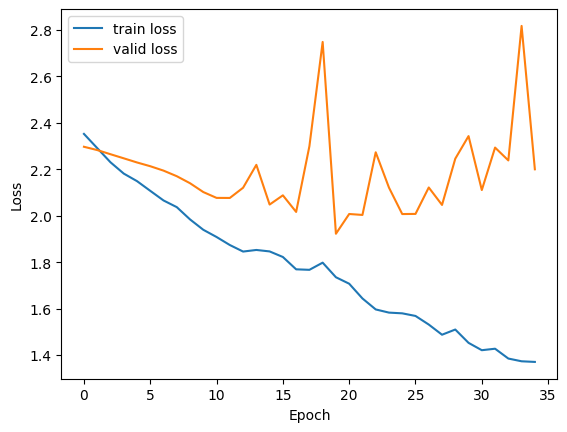

In [697]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

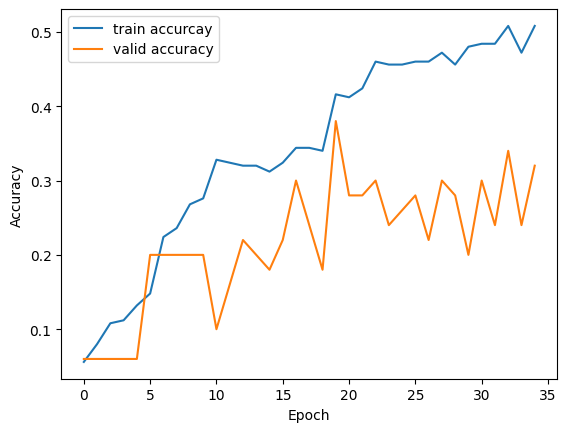

In [698]:
plt.plot(range(N), acc_train_hist, label = 'train accurcay')
plt.plot(range(N), acc_valid_hist, label = 'valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [699]:
transforms_train = T.Compose([T.ToTensor(),
                              T.Resize(size = (64, 64)),
                             T.RandomGrayscale(0.5)])

In [700]:
data = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', 
                            transform = transforms_train)

In [701]:
t, _ = random_split(data, (200, len(data)-200), generator = tc.Generator().manual_seed(42))

In [702]:
train_dataset, valid_dataset = random_split(t, (150, len(t)-150), generator = tc.Generator().manual_seed(42))

In [703]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [704]:
optimizer = optim.Adam(model.parameters(), lr = 0.000000000000001)
loss_func = nn.CrossEntropyLoss()

In [705]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

In [706]:
N = 25
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 3/3 [00:02<00:00,  1.29batch/s, Accuracy=37.3, loss=1.89]


valid loss=2.106, accuracy=30.0



Epoch=1: 100%|██████████| 3/3 [00:02<00:00,  1.27batch/s, Accuracy=38.7, loss=1.73]


valid loss=1.961, accuracy=34.0



Epoch=2: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=41.3, loss=1.86]


valid loss=1.925, accuracy=38.0



Epoch=3: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s, Accuracy=39.3, loss=1.7] 


valid loss=1.746, accuracy=36.0

model saved!


Epoch=4: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=40, loss=1.71]  


valid loss=1.694, accuracy=42.0

model saved!


Epoch=5: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=40.7, loss=1.84]


valid loss=1.929, accuracy=34.0



Epoch=6: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=40.7, loss=1.76]


valid loss=1.879, accuracy=36.0



Epoch=7: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=38, loss=1.87]  


valid loss=1.928, accuracy=34.0



Epoch=8: 100%|██████████| 3/3 [00:01<00:00,  1.55batch/s, Accuracy=37.3, loss=1.68]


valid loss=1.875, accuracy=30.0



Epoch=9: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=40.7, loss=1.74]


valid loss=1.751, accuracy=38.0



Epoch=10: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=41.3, loss=1.84]


valid loss=1.751, accuracy=42.0



Epoch=11: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s, Accuracy=40, loss=1.76]  


valid loss=1.846, accuracy=38.0



Epoch=12: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=36.7, loss=1.84]


valid loss=1.799, accuracy=34.0



Epoch=13: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=37.3, loss=1.89]


valid loss=1.686, accuracy=34.0

model saved!


Epoch=14: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=40.7, loss=1.78]


valid loss=1.867, accuracy=34.0



Epoch=15: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=36, loss=1.82]  


valid loss=1.786, accuracy=40.0



Epoch=16: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=39.3, loss=1.65]


valid loss=1.77, accuracy=42.0



Epoch=17: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=37.3, loss=1.84]


valid loss=1.854, accuracy=38.0



Epoch=18: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=37.3, loss=1.84]


valid loss=1.781, accuracy=38.0



Epoch=19: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=36.7, loss=1.86]


valid loss=1.941, accuracy=32.0



Epoch=20: 100%|██████████| 3/3 [00:02<00:00,  1.31batch/s, Accuracy=41.3, loss=1.63]


valid loss=1.892, accuracy=34.0



Epoch=21: 100%|██████████| 3/3 [00:02<00:00,  1.32batch/s, Accuracy=37.3, loss=1.85]


valid loss=1.733, accuracy=42.0



Epoch=22: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s, Accuracy=36.7, loss=1.7] 


valid loss=1.935, accuracy=38.0



Epoch=23: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s, Accuracy=37.3, loss=1.78]


valid loss=1.883, accuracy=34.0



Epoch=24: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s, Accuracy=38.7, loss=1.75]


valid loss=1.839, accuracy=32.0



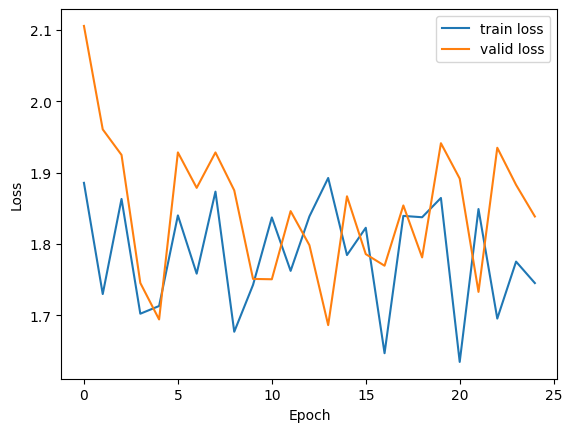

In [707]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()